<hr style="color:green" />
<h1 style="color:green">COSC2673 Assignment 2: Image Classification for Cancerous Cells</h1>
<h2 style="color:green">File 30: Modelling on the Full data For the Canceorous Binary Classification</h2>
<hr style="color:green" />

<p>
After Reviewing files 22, 24, 25 and 26, we have experimented with improving the performance of the CNN with more complexity in the Convolutions and the Classifier layers. Taking into account performance increases but also processing time and complexity, the following model will be used here:
</p>
<ul>
<li>CNN with more complex convolutions (from file 24)</li>
</ul>
<p>
Now, in an attempt to improve the performance of both the Binary and the Multiclass models, this process will make use of the full data, ie. both the Main Labels file and the Extras Label file. Because handling these two will be different, processing will be split into separate notebooks.
</p>

<ul>
<li>Binary IsCancerous (here): All data is labeled, so just add the new data to the dataset</li>
<li>Multiclass Cell Type: The data in the Extras file are unlabeled, so therefore, we will need to apply a Semi Supervised Learning approach</li>
</ul>
<p>
In this file, also load the Extra Label data, train the Binary Classification model and evaluate
</p>

In [18]:
import pandas as pd
import numpy as np
import os
import cv2

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torch.utils.data
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.io import read_image


Configure this script as to whether it runs on Google Colab, or locally

In [19]:
# When on Google Colab, running full training, change both to true. Locally, advised set both to false
isGoogleColab = False
useFullData = False

In [20]:
# In local, the base directory is the current directory
baseDirectory = "./"

if isGoogleColab:
    from google.colab import drive
    
    # If this is running on Google colab, assume the notebook runs in a "COSC2673" folder, which also contains the data files 
    # in a subfolder called "image_classification_data"
    drive.mount("/content/drive")
    !ls /content/drive/'My Drive'/COSC2673/

    # Import the directory so that custom python libraries can be imported
    import sys
    sys.path.append("/content/drive/MyDrive/COSC2673/")

    # Set the base directory to the Google Drive specific folder
    baseDirectory = "/content/drive/MyDrive/COSC2673/"

Import the custom python files that contain reusable code

In [21]:
import data_basic_utility as dbutil
import graphing_utility as graphutil
import statistics_utility as statsutil

import a2_utility as a2util
import pytorch_utility as ptutil
from pytorch_utility import CancerBinaryDataset
from pytorch_utility import CancerCellTypeDataset


# randomSeed = dbutil.get_random_seed()
randomSeed = 266305
print("Random Seed: " + str(randomSeed))

Random Seed: 266305


In [22]:
# this file should have previously been created in the root directory
dfImages = pd.read_csv(baseDirectory + "images_main.csv")
dfImagesExtra = pd.read_csv(baseDirectory + "images_extra.csv")

In [23]:
# Get The training, validation and test Splits of the Main Data
dfImagesTrain = dfImages[dfImages["trainValTest"] == 0]
dfImagesVal = dfImages[dfImages["trainValTest"] == 1]
dfImagesTest = dfImages[dfImages["trainValTest"] == 2]

# Get the Extra Data training, validation and test Splits
dfExtraTrain = dfImagesExtra[dfImagesExtra["trainValTest"] == 0]
dfExtraVal = dfImagesExtra[dfImagesExtra["trainValTest"] == 1]
dfExtraTest = dfImagesExtra[dfImagesExtra["trainValTest"] == 2]

# Append the extra data to the data to use from the main data
dfImagesTrain = dfImagesTrain.append(dfExtraTrain).reset_index()
dfImagesVal = dfImagesVal.append(dfExtraVal).reset_index()
dfImagesTest = dfImagesTest.append(dfExtraTest).reset_index()

print(dfImagesTrain.shape)
print(dfImagesVal.shape)
print(dfImagesTest.shape)

dfImagesTrain.head()

(16603, 5)
(1823, 5)
(1854, 5)


,index,ImageName,isCancerous,cellType,trainValTest
0,0,./Image_classification_data/patch_images\1.png,0,0,0
1,1,./Image_classification_data/patch_images\10.png,0,0,0
2,3,./Image_classification_data/patch_images\1000.png,1,2,0
3,4,./Image_classification_data/patch_images\10000...,0,1,0
4,5,./Image_classification_data/patch_images\10001...,0,1,0


Note: The definition of the Custom Datasets for both the isCancerous data and the Cell Type data are defined in the pytorch_utility.py file.

Also, rather than loading all the training images and calculating the mean and standard deviation values in here, that was run separately in file 05a.PyTorchGetMeanAndStd.ipynb

Here we can just define the values to use, which shouldn't change unless the data is reloaded and a new train/validation/test split is generated

In [24]:
train_mean, train_std = ptutil.getTrainMeanAndStdTensors()
print(train_mean)
print(train_std)

tensor([0.8035, 0.5909, 0.7640])
tensor([0.1246, 0.1947, 0.1714])


In [25]:
# Create a tranform operation that also normalizes the images according to the mean and standard deviations of the images
transform_normalize = transforms.Compose(
    [transforms.ToPILImage(),
    transforms.ToTensor(), 
    transforms.Normalize(train_mean, train_std)])


In [26]:
cancerous_training_data = None

# Create a custom Dataset for the training and validation data
if useFullData:
    cancerous_training_data = CancerBinaryDataset(isGoogleColab, dfImagesTrain, baseDirectory, transform=transform_normalize)
else:
    # For testing in a small dataset
    dfImagesTrainTest = dfImagesTrain.iloc[range(1000), :].reset_index()
    cancerous_training_data = CancerBinaryDataset(isGoogleColab, dfImagesTrainTest, baseDirectory, transform=transform_normalize, target_transform=None)

cancerous_validation_data = CancerBinaryDataset(isGoogleColab, dfImagesVal, baseDirectory, transform=transform_normalize, target_transform=None)
cancerous_test_data = CancerBinaryDataset(isGoogleColab, dfImagesTest, baseDirectory, transform=transform_normalize, target_transform=None)

# Create data loaders
cancerous_train_dataloader = DataLoader(cancerous_training_data, batch_size=32, shuffle=True, num_workers=2)
cancerous_val_dataloader = DataLoader(cancerous_validation_data, batch_size=32, shuffle=True, num_workers=2)
cancerous_test_dataloader = DataLoader(cancerous_test_data, batch_size=32, shuffle=True, num_workers=2)

# Early Stopping

Using the basic model (class), refactor the code such that the test and validation predictions are made at the end of each epoch and the loss difference between training error and validation error are calculated. Use the F1 Score as the metric

Also implement a "Patience" level, where the patience is the number of consecutive epochs that can occur with no improvement in loss before the process is stopped early.

In [27]:
# Create a class for the Neural Network
class PT_CNN_IsCancerous(nn.Module):

    # In the constructor, initialize the layers to use
    def __init__(self):
        super(PT_CNN_IsCancerous, self).__init__()

        # first, define the subsampling methods. Though they are used multiple times, these are the
        # operations, so only need to be defined once
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        # define the Activation methods to use
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

        # define the convolution layers

        # Applied a greyscale, reducing channels from 3 to 1
        # input should be 27x27x3. Apply a 3x3 filter, therefore, output should be 23x23x64 (channels aka feature maps)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=1)
        # There will be a Relu
        # Then a MaxPool of 2x2, halving the dimensions per feature map
        # So input is 11x11x32. Apply a 3x3 filter, also include padding=1, as this is already quite small, and lets consider the edges
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)    
        # There will be a Relu    
        # Then a MaxPool of 2x2, halving the dimensions per feature map    
        # So input is 5x5x64. Apply a 3x3 filter
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        # Then a MaxPool of 2x2, halving the dimensions per feature map
        # Final output is 2x2
        
        # define the fully connected neural layers
        self.fc1 = nn.Linear(256 * 2 * 2, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 2)

    # Create the forward function, which is used in training
    def forward(self, x):


        # print("Init Shape: " + str(x.shape))
        # print("  Shape 1: " + str(x.shape))

        # Process the first 2 convolution layers, applying maxpooling
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)

        # Then process the remaining convolution layers without any pooling
        x = self.relu(self.conv2(x))     
        x = self.maxpool(x)  
        x = self.relu(self.conv3(x))

        # Then apply a max pool and average pool on the result
        x = self.maxpool(x)
        #x = self.avgpool(x)

        # Flatten: This should convert to tensors that are acceptable for the input into the NN 3 layers
        x = x.view(x.size(0), 256 * 2 * 2)

        # Now process the 3 layers of the Fully Connected NN
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))        
        # x = self.relu(self.fc3(x))        
        # x = self.fc3(x)        

        # return the result
        return x


Now train the Fully Connected Neural Network Model.

During training, we will use the following:
- Softmax Cross Entropy Loss as our Loss function. This is a good Loss function that basically converts scores for each class into probabilities
- The Adam Optimizer, which is a version of Gradient Descent
- Initially, just 10 epochs

Create a function to predict

In [28]:
def predictCancerousOnDataSetF1(net, setName, dataloader, printResult=True, printFullResults=False):
    correct, total = 0,  0
    predictions = []

    y_cancerous = []
    y_pred_cancerous = []

    # Looping through this dataloader essentially processes them in batches of 32 (or whatever the batchsize is configured in the data loader
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data

        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        # Loop through the batch, build the lists of the raw label and prediction values
        for j in range(len(labels)):
            y_cancerous.append(labels[j].item())
            y_pred_cancerous.append(predicted[j].item())

        predictions.append(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    f1Score = f1_score(y_cancerous, y_pred_cancerous)

    if printFullResults:
        print(setName + ":")        
        print('Confusion matrix: \n')
        print(confusion_matrix(y_cancerous, y_pred_cancerous))
        print("\n- Accuracy Score: " + str(accuracy_score(y_cancerous, y_pred_cancerous)))
        print("- Precision Score: " + str(precision_score(y_cancerous, y_pred_cancerous)))
        print("- Recall Score: " + str(recall_score(y_cancerous, y_pred_cancerous)))
        print("- F1 Score: " + str(f1Score))
    elif printResult:
        print("- " + setName + " F1: " + str(f1Score))        

    return f1Score, y_cancerous, y_pred_cancerous

In [29]:
# set the Learning Rate to use
learning_rate = 0.0001
maxEpochs = 15
patience = 3
disableEarlyStopping = True
criterion = nn.CrossEntropyLoss()

# Use this for L2 Regularization
# net = PT_NN_IsCancerous()
# optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.0001)

# Use this for dropouts
net = PT_CNN_IsCancerous()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

bestErrorDiff = 99999
concurrentNonImproves = 0
currentEpoch = 0

bestValF1 = -1
lstEpochs = []
lstTrainF1s = []
lstValF1s = []
for epoch in range(maxEpochs):
    print("Starting Epoch " + str(epoch) + "...")
    currentEpoch = epoch

    # Set the Neural Network into training mode
    net.train()

    # Train through this epoch
    for i, data in enumerate(cancerous_train_dataloader, 0):
        # Get the inputs
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Perform Forward and Backward propagation then optimize the weights
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # Set the Neural Network into evaluation (test) mode, so we can evaluate both training and validation error
    net.eval()        
    trainingF1, y_train_cancerous, y_train_pred_cancerous = predictCancerousOnDataSetF1(net, "Training", cancerous_train_dataloader, True, False)
    validationF1, y_val_cancerous, y_val_pred_cancerous = predictCancerousOnDataSetF1(net, "Validation", cancerous_val_dataloader, True, False)

    errorDiff = trainingF1 - validationF1
    print("- F1 Difference: " + str(errorDiff))

    lstEpochs.append(epoch)
    lstTrainF1s.append(trainingF1)
    lstValF1s.append(validationF1)

    if epoch > 0 and (validationF1 - bestValF1 > 0.01):        
        # There is at least percentage point improvement in the validation F1, count this as a 
        # good iteration, regardless of the error difference
        print("- IsGoodStep")
        concurrentNonImproves = 0
        if errorDiff > 0 and errorDiff < bestErrorDiff:  
            bestErrorDiff = errorDiff        
    elif errorDiff < bestErrorDiff:        
        # This epoch is an improvement on the last, so we will continue. the concurrent non improve counts reset for the patience
        print("- IsBetter: " + str(errorDiff) + " : " + str(bestErrorDiff))        
        concurrentNonImproves = 0
        if errorDiff > 0:
            bestErrorDiff = errorDiff
    else:
        # This epoch has the same or worse performance than the last. Check if we have reached the patience, if so, then stop early
        print("- IsNotBetter: " + str(errorDiff) + " : " + str(bestErrorDiff))        
        concurrentNonImproves += 1
        if disableEarlyStopping == False:
            if concurrentNonImproves >= patience:
                print("Early Stopping occurred at Epoch " + str(epoch))
                break

    # update the val F1 score from the previous epoch if it's the best
    if validationF1 > bestValF1:
        bestValF1 = validationF1


    

Starting Epoch 0...
- Training F1: 0.7816513761467889
- Validation F1: 0.7715582450832073
- F1 Difference: 0.010093131063581673
- IsBetter: 0.010093131063581673 : 99999
Starting Epoch 1...
- Training F1: 0.8381742738589212
- Validation F1: 0.8141670310450371
- F1 Difference: 0.02400724281388411
- IsGoodStep
Starting Epoch 2...
- Training F1: 0.8828980623420387
- Validation F1: 0.8198810535259135
- F1 Difference: 0.06301700881612526
- IsNotBetter: 0.06301700881612526 : 0.010093131063581673
Starting Epoch 3...
- Training F1: 0.861878453038674
- Validation F1: 0.8261648745519714
- F1 Difference: 0.035713578486702646
- IsNotBetter: 0.035713578486702646 : 0.010093131063581673
Starting Epoch 4...
- Training F1: 0.875889328063241
- Validation F1: 0.7932826869252297
- F1 Difference: 0.0826066411380113
- IsNotBetter: 0.0826066411380113 : 0.010093131063581673
Starting Epoch 5...
- Training F1: 0.8912097476066144
- Validation F1: 0.8277347114556417
- F1 Difference: 0.06347503615097272
- IsNotBett

Look at the training and validation loss plot to track how the model improved during epochs

<module 'matplotlib.pyplot' from 'C:\\Users\\nelso\\AppData\\Roaming\\Python\\Python39\\site-packages\\matplotlib\\pyplot.py'>

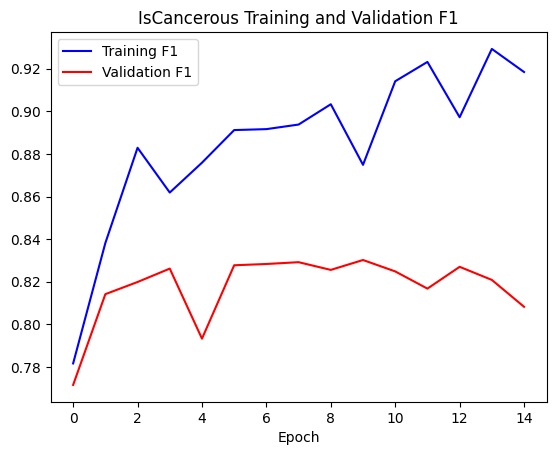

In [30]:
dfLoss = pd.DataFrame({ 'epoch': lstEpochs, 'train': lstTrainF1s, 'validation': lstValF1s })
graphutil.graphBasicTwoSeries(dfLoss, "epoch", "train", "validation", "IsCancerous Training and Validation F1", 
        "Epoch", "Training F1", "Validation F1")

Training Time in Nelson's Local Environment on the full data takes a very long time, stopped after 100 minutes. This will need to be done in Colab.

First, Predict on the training data so that we can find the training error.

In [31]:
# Use the final NN model to predict on the training data
trainingF1, y_train_cancerous, y_train_pred_cancerous = predictCancerousOnDataSetF1(net, "Training", cancerous_train_dataloader, True, True)

Training:
Confusion matrix: 

[[350  76]
 [ 22 552]]

- Accuracy Score: 0.902
- Precision Score: 0.8789808917197452
- Recall Score: 0.9616724738675958
- F1 Score: 0.91846921797005


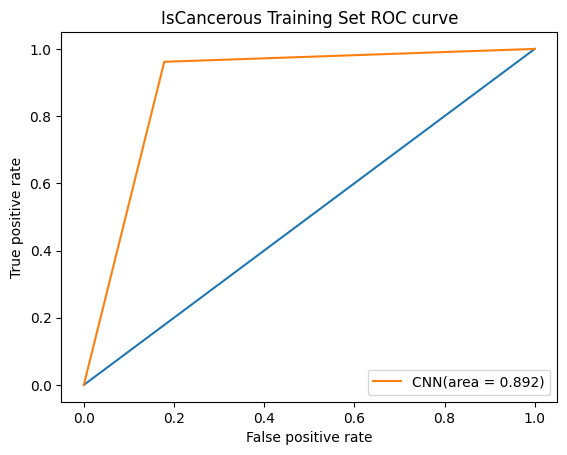

ROC (Area): 0.8916343589995256


0.8916343589995256

In [32]:
a2util.getClassificationROC("IsCancerous", "Training", y_train_cancerous, y_train_pred_cancerous)

Now Predict according to the Validation data and evaluate. While looping through here, we will need to get out the Labels from the data loader, because the order of predictions in the batches do not match the order of the original Target values in the dataset (because we turned Shuffle on)

In [33]:
testF1, y_test_cancerous, y_test_pred_cancerous = predictCancerousOnDataSetF1(net, "Test", cancerous_test_dataloader, True, True)

Test:
Confusion matrix: 

[[362 488]
 [ 19 985]]

- Accuracy Score: 0.7265372168284789
- Precision Score: 0.6687033265444671
- Recall Score: 0.9810756972111554
- F1 Score: 0.7953169156237383


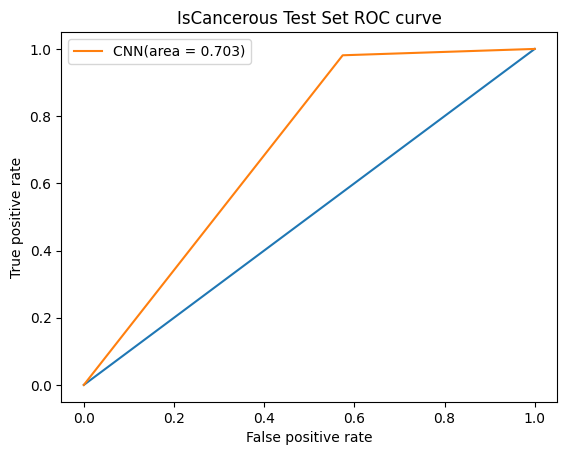

ROC (Area): 0.703479025076166


0.703479025076166

In [34]:
a2util.getClassificationROC("IsCancerous", "Test", y_test_cancerous, y_test_pred_cancerous, 2)

# Results

Append Results for both Binary IsCancerous and Cell Type here

### IsCancerous Results



<h1>Analysis of Performance and Accuracy</h1>

<h3>Is Cancerous</h3>
<p>
The best performing model after initial CNN experiments, according to F1 Score, is the CNN with 3 Layer Classifier, with no Early stopping. the F1 Score is <strong>0.907</strong>, which is only a 0.01 improvement on the Basic NN 2 Layer model.
</p>
<p>
However, we can see that the difference between the Training F1 and the Test F1 in this CNN is a lot smaller, with the Training F1 being 0.93. This is a situation where we have higher bias but less variance, with higher bias compared to other experiments. Therefore, it may be possible to model with more accuracy to reduce the bias, however, we must be careful not to overfit.
</p>


